## Prepare invironment

In [14]:
# correct flats headers
#from functools import partial
#p = '/home/ser/Dev/astro_engine/spark_pipeline/spark_pipeline_test_1/temp/flat'
#f = filter_fits_by_header(input_images_names, paths['temp']+'/flat', EXPTYPE='Light')
#change_header_apply = partial(change_header, fits_path=p, EXPTYPE=to_header_str_format('Flat'))
#apply_to_fits(f, p, change_header_apply)

In [9]:
# take lists of each type images
#input_images_names = sorted(get_fits_images_from_dir(os.path.join(paths['temp']), '.fts', True, True))
#bias_list = filter_fits_by_header(input_images_names, paths['temp'], IMAGETYP='Bias')
#dark_list = filter_fits_by_header(input_images_names, paths['temp'], IMAGETYP='Dark Frame')
#flat_list = filter_fits_by_header(input_images_names, paths['temp'], IMAGETYP='Flat Field')
#images_list = filter_fits_by_header(input_images_names, paths['temp'], IMAGETYP='Light Frame')

In [153]:
# superbias
#iraf.noao.imred(_doprint=0)
#iraf.noao.imred.ccdred(_doprint=0)
#iraf.noao.imred.ccdred.instrument = os.path.join(paths['config'], 'instrument.dat')
#iraf.noao.imred.ccdred.zerocombine.setParam('ccdtype', "")  
#gain = fits.getheader(bias_list[0], 0)['GAIN']
#iraf.noao.imred.ccdred.zerocombine.setParam('gain', gain) 
#bias_list_txt = os.path.join(paths['temp'], 'super', 'bias_list.txt')
#list_to_file(bias_list, bias_list_txt)
#superbias_filename = os.path.join(paths['temp'], 'super', 'superbias.fits')
#iraf.noao.imred.ccdred.zerocombine(input='@' + bias_list_txt, output=superbias_filename, 
                                       #process='no', delete='no', clobber='no')

In [155]:
# compute darks_exp_times, key:filename, value:exp_time
darks_exp_times_dict = header_keywords_values(dark_list, keywords=['EXPTIME'])
if 'EXPTIME' in darks_exp_times_dict.keys():
    darks_exp_times = sorted(darks_exp_times_dict['EXPTIME'].keys())
else:
    darks_exp_times = []
print 'darks exp times:', darks_exp_times

# for each image filter, find best dark for flat and flat for image
filters = ['R']
filters_exp_times_mappings = {}
for filter_ in filters:
    print 'filter:', filter_
    # filter fits with current filter
    filter_flat_list = filter_fits_by_header(flat_list, paths['temp'], FILTER=filter_)
    filter_images_list = filter_fits_by_header(images_list, paths['temp'], FILTER=filter_)
    
    # compute flats_exp_times
    flats_exp_times_dict = header_keywords_values(filter_flat_list, keywords=['EXPTIME'])
    if 'EXPTIME' in flats_exp_times_dict.keys():
        flats_exp_times = sorted(flats_exp_times_dict['EXPTIME'].keys())
    else:
        flats_exp_times = []
    print 'flats exp times:', flats_exp_times

    # compute images_exp_times
    images_exp_times_dict = header_keywords_values(filter_images_list, keywords=['EXPTIME'])
    if 'EXPTIME' in images_exp_times_dict.keys():
        images_exp_times = sorted(images_exp_times_dict['EXPTIME'].keys())
    else:
        images_exp_times = []
    print 'images exp times:', images_exp_times

    # search for best dark_exp_times for images
    images_darks_exp_times = best_exp_time(images_exp_times, darks_exp_times)
    print "best darks exp time for images:", images_darks_exp_times

    # search for best dark_exp_times for flats
    flat_darks_exp_times = best_exp_time(flats_exp_times, darks_exp_times)
    print "best darks exp time for flats:", flat_darks_exp_times

    # search for best flat_exp_times for images
    images_flats_exp_times = best_exp_time(images_exp_times, flats_exp_times)
    print "best flats exp time for images:", images_flats_exp_times
    
    filters_exp_times_mappings[filter_] = {'images-dark': images_darks_exp_times, 
                                           'flat-dark': flat_darks_exp_times,
                                           'images-flat': images_flats_exp_times}

darks exp times: [2.0, 60.0]
filter: R
flats exp times: []
images exp times: [60.0]
best darks exp time for images: {60.0: 60.0}
best darks exp time for flats: {}
best flats exp time for images: {}


In [156]:
filters_exp_times_mappings

{'R': {'flat-dark': {}, 'images-dark': {60.0: 60.0}, 'images-flat': {}}}

In [178]:
# when we know which dark needed for which flat and which image, so compute all needed darks
exp_times_superdarks = {}
for filter_, mapps in filters_exp_times_mappings.iteritems():
    for mapp, vals in mapps.iteritems():
        for_, by_ = mapp.split('-')[0], mapp.split('-')[1]
        if vals and by_ == 'dark':
            for k, v in vals.iteritems():
                superdark_filename = os.path.join(paths['temp'], 'super',
                                                  'superdark_%s_%s_%d.fits' % (filter_, for_, k))
                input_darks_list = darks_exp_times_dict['EXPTIME'][v]
                scale_coeff = float(k) / float(v)
                iraf.noao.imred(_doprint=0)
                iraf.noao.imred.ccdred(_doprint=0)
                iraf.noao.imred.ccdred.instrument = os.path.join(paths['config'], 'instrument.dat')
                iraf.noao.imred.ccdred.darkcombine.setParam('ccdtype', "")  
                gain = fits.getheader(input_darks_list[0], 0)['GAIN']
                iraf.noao.imred.ccdred.darkcombine.setParam('gain', gain)
                iraf.noao.imred.ccdred.darkcombine.setParam('scale', 'exposure')
                iraf.noao.imred.ccdred.darkcombine.setParam('combine', 'median')
                iraf.noao.imred.ccdred.darkcombine.setParam('process', 'no')
                dark_list_txt = os.path.join(paths['temp'], 'super', 'dark_list.txt')
                list_to_file(input_darks_list, dark_list_txt)
                iraf.noao.imred.ccdred.darkcombine(input='@' + dark_list_txt, output=superdark_filename)
                # TODO: subtract superbias
                
                #iraf.module.imarith.lParam()
                sub_1 = 'temp/super/superdark.txt'
                sub_2 = 'temp/super/superbias.txt'
                list_to_file([superdark_filename], sub_1)
                list_to_file([superbias_filename], sub_2)
                iraf.module.imarith('@'+sub_1, '-', '@'+sub_2, 'res.fits')
                
# 
for filter_, mapps in filters_exp_times_mappings.iteritems():
    print 'filter:', filter_
    for mapp, vals in mapps.iteritems():
        for_, by_ = mapp.split('-')[0], mapp.split('-')[1]
        if not vals:
            print 'don\'t use', by_, 'for', for_, 'for this filter'
        else:
            for k, v in vals.iteritems():
                coef_str = 'coeff = %f' %(float(k)/float(v)) if by_ == 'dark' else ''
                print 'use', by_, 'with exp_time', v, 'for', for_, 'with exp_time', k, coef_str

/home/ser/Dev/astro_engine/spark_pipeline/spark_pipeline_test_1/temp/super/superdark_R_images_60.fits is not an image or a number


filter: R
use dark with exp_time 60.0 for images with exp_time 60.0 coeff = 1.000000
don't use flat for images for this filter
don't use dark for flat for this filter


In [102]:
# compute superdark for each flat exp_times

{2.0: 12, 60.0: 60}

In [101]:
def best_exp_time(exp_list_for, exp_list_by):
    res = {}
    if not exp_list_by or not exp_list_for:
        return res
    for iet in exp_list_for:
        min_diff = abs(exp_list_by[0] - iet)
        best_det = exp_list_by[0]
        for det in exp_list_by:
            diff = abs(det - iet)
            if diff < min_diff:
                best_det = det
                min_diff = diff
        res[iet] = best_det
    return res

<h2>Pipeline (local version)</h2>

<h3>Import all needed packages</h3>

In [1]:
import os
import datetime
import copy
import astromatic_wrapper as aw #TODO: install aw to itaf virtual env
from astropy.io import fits
import pyraf
from pyraf import iraf
import sys
sys.path.insert(0, '/home/ser/Dev/astro_engine/code')
from astro_utils import AEDirsTreeConfigurer, AEJsonConfigLoader
from fits_utils import *

<h3>Define pipeline parameters</h3>

In [6]:
#EXPTYPE - FITS header keywords for type of frame
#Bias - bias
#Dark - dark
#Light - flat

In [7]:
#print(pyraf.__version__)
#iraf.pwd()
#from pyraf import irafinst
#irafinst.getIrafVer()

#iraf.files(bias_list)

#iraf.images(_doprint=0) # load images
#iraf.imutil(_doprint=0) # load imutil
#iraf.imheader.setParam('longheader', 'yes')
#iraf.imheader(bias_list[0])

2.2.dev


In [2]:
def list_to_file(list_, filename, sep='\n'):
    with open(filename, 'w') as fid:
        for item in list_:
            fid.write('%s%s' % (str(item), sep))

def to_list(something):
    return something if isinstance(something, list) else [something]

def filter_fits_by_header(fits_filenames, fits_path=None, match_any=False, ignore_case=True,
                          ignore_edge_spaces=True, hdu_num=0, **kwargs):
    iffs = [os.path.join(fits_path, os.path.basename(iff)) if fits_path is not None else iff\
            for iff in to_list(fits_filenames)]
    res = []
    for iff in iffs:
        fits_file_header = fits.getheader(iff, hdu_num)
        keywords_match = 0
        for keyword, value in kwargs.iteritems():
            if keyword in fits_file_header:
                header_val = str(fits_file_header[keyword]).strip() if ignore_edge_spaces \
                else str(fits_file_header[keyword])
                header_val = header_val.lower() if ignore_case else header_val
                kwargs_val = str(value).strip() if ignore_edge_spaces else str(value)
                kwargs_val = kwargs_val.lower() if ignore_case else kwargs_val
                if header_val == kwargs_val:
                    keywords_match += 1
                    if match_any:
                        break
        if (keywords_match and match_any) or (keywords_match == len(kwargs)):
            res.append(iff)
    return res

def header_keywords_values(fits_filenames, fits_path=None, keywords=['SIMPLE'], keys_keywords=True, lower_case=True,
                           split_edge_spaces=True, hdu_num=0):
    iffs = [os.path.join(fits_path, os.path.basename(iff)) if fits_path is not None else iff \
            for iff in to_list(fits_filenames)]
    kws = to_list(keywords)
    res = {}
    for iff in iffs:
        fits_file_header = fits.getheader(iff, hdu_num)
        if keys_keywords:
            for keyword in kws:
                if keyword not in res.keys():
                    res[keyword] = {}
                if keyword in fits_file_header:
                    val = fits_file_header[keyword]
                    if val not in res[keyword].keys():
                        res[keyword][val] = []
                    res[keyword][val].append(iff)
        else:   
            for keyword in kws:
                if keyword in fits_file_header:
                    res[iff] = {keyword: fits_file_header[keyword]}
                else:
                    res[iff] = {keyword: None}
    return res

def change_header(fits_filename, fits_path=None, new_path=None, clobber=True, **kwargs):
    iff = os.path.join(fits_path, os.path.basename(fits_filename)) if fits_path is not None else fits_filename
    data, header = fits.getdata(iff, header=True)
    for keyword, value in kwargs.iteritems():
        if value is None:
            header.remove(keyword, True, True)
        else:
            header[keyword] = value
    if new_path is None:
        new_path = os.path.dirname(iff)
    iff = os.path.join(new_path, os.path.basename(iff))
    fits.writeto(iff, data, header, clobber=clobber)
    return iff

def fits_ImageHDU_from_file(filename, mode='denywrite', lazy_load_hdus=False):
    f = fits.open(filename, mode='denywrite', lazy_load_hdus=False)
    fits_image = fits.ImageHDU(data=f[0].data, header=f[0].header)
    f.close()
    return fits_image

def to_header_str_format(str_value, length=8):
    return str_value.strip().ljust(length)

def apply_to_fits(fits_filenames, fits_path=None, func=None):
    iffs = [os.path.join(fits_path, os.path.basename(iff)) if fits_path is not None else iff \
            for iff in to_list(fits_filenames)]
    if not func:
        return iffs
    res = []
    for iff in iffs:
        res.append(func(iff))
    return res

def images_stat(images, fields='mode,mean', return_dict=True, stdout=1, stderr=2):
    iraf.images(_doprint=0)
    if return_dict:
        iraf.images.imstat.setParam('format', 'no')
        #iraf.images.imstat.setParam('')
    iraf.images.imstat.setParam('fields', fields)
    images = images if isinstance(images, list) else [images]
    res = []
    for image in images:
        res.append(iraf.imstat(image, Stdout=stdout, Stderr=stderr))
    return res

gain_for_raw_images = 0.16400855506412962

gain_for_basic_reduced_images = 0.14559281953978367

In [809]:
# take lists of each type images
#input_images_names = sorted(get_fits_images_from_dir(os.path.join(paths['temp']), '.fts', True, True))
#bias_list = filter_fits_by_header(input_images_names, paths['temp'], IMAGETYP='Bias')
#dark_list = filter_fits_by_header(input_images_names, paths['temp'], IMAGETYP='Dark Frame')
#flat_list = filter_fits_by_header(input_images_names, paths['temp'], IMAGETYP='Flat Field')
#images_list = filter_fits_by_header(input_images_names, paths['temp'], IMAGETYP='Light Frame')

In [56]:
#from functools import partial
#gain_for_basic_reduced_images = 0.14559281953978367
#part_c_h = partial(change_header, GAIN=gain_for_basic_reduced_images)
#apply_to_fits(images_list, func=part_c_h)

In [62]:
# PROCESS HEADERS
#first_header = fits.getheader(images_list[0], 0)
#last_header = fits.getheader(images_list[-1], 0)

#common_keywords = ['CTYPE1', 'CTYPE2', 'CRPIX1','CRPIX2']
#common_vals_dict = {ch_k: first_header[ch_k] for ch_k in common_keywords} 

#ch_keywords = ['CDELT1', 'CDELT2', 'CROTA1', 'CROTA2', 'CRVAL1', 'CRVAL2']
#first_dict = {ch_k: first_header[ch_k] for ch_k in ch_keywords} 
#last_dict = {ch_k: last_header[ch_k] for ch_k in ch_keywords}
#diff_dict = {ch_k: abs(first_header[ch_k] - last_header[ch_k]) for ch_k in ch_keywords}
#import numpy as np
#linspaces_dict = {ch_k: np.linspace(first_dict[ch_k], last_dict[ch_k], len(images_list)) for ch_k in ch_keywords}

#for i in xrange(len(images_list)):
    #i_dict = {}
    #for k, v in linspaces_dict.iteritems():
        #i_dict[k] = v[i]
    #for k, v in common_vals_dict.iteritems():
        #i_dict[k] = v
    #change_header(images_list[i], **i_dict)
    
# paste here code to remove some keywords from headers


<h4>Basic reduction</h4>

In [3]:
def compute_superbias(input_images_names, paths, pipeline_config, pipeline_stage, pipeline_step):
    # TODO: check config, stage and step for needed for this function keys
    # select pipeline stage and step in config
    step_config = copy.deepcopy(pipeline_config['pipeline_stages'][pipeline_stage]['stage_steps'][pipeline_step])
    step_params_config = step_config['step_params']
    software_params = step_params_config['software_params']
    
    input_tech_frames_dir = paths[step_params_config['input_params']['tech_frames']['frames_dir']]
    output_tech_frames_dir = paths[step_params_config['output_params']['tech_frames']['frames_dir']]

    input_bias_config = step_params_config['input_params']['tech_frames']['bias']
    input_bias_config['format'] = to_ext_format(input_bias_config['format'])
    output_bias_config = step_params_config['output_params']['tech_frames']['bias']
    output_bias_config['format'] = to_ext_format(output_bias_config['format'])
    
    input_bias_dir = os.path.join(input_tech_frames_dir, input_bias_config['sub_dir'])
    output_bias_dir = os.path.join(output_tech_frames_dir, output_bias_config['sub_dir'])

    superbias_filename = os.path.join(output_bias_dir,
                                      (output_bias_config['name'] + output_bias_config['format']))

    filter_bias_kwargs = {input_bias_config['type_keyword']: input_bias_config['type_keyword_value']}
    input_bias_filenames = filter_fits_by_header(input_images_names, input_bias_dir, 
                                                 **filter_bias_kwargs)
    
    iraf.noao.imred(_doprint=0)
    iraf.noao.imred.ccdred(_doprint=0)
    iraf.noao.imred.ccdred.instrument = os.path.join(paths[software_params['config']['INSTRUMENT_DIR']],
                                                     software_params['config']['INSTRUMENT_FILE'])
    
    if 'ccdtype' in input_bias_config.keys():
        iraf.noao.imred.ccdred.zerocombine.setParam('ccdtype', input_bias_config['ccdtype'])
    else:
        iraf.noao.imred.ccdred.zerocombine.setParam('ccdtype', '')
    if 'gain_keyword' in input_bias_config.keys():
        gain = fits.getheader(input_bias_filenames[0], 0)[input_bias_config['gain_keyword']]
        iraf.noao.imred.ccdred.zerocombine.setParam('gain', gain)
    
    bias_list = os.path.join(paths['temp'], 'bias_list.txt')
    list_to_file(input_bias_filenames, bias_list)
    
    iraf.noao.imred.ccdred.zerocombine(input='@' + bias_list, output=superbias_filename, 
                                       process='no', delete='no', clobber='no')
    
    return superbias_filename

In [4]:
def compute_supers(input_images_names, paths, pipeline_config, pipeline_stage, pipeline_step):
    # TODO: check config, stage and step for needed for this function keys
    # select pipeline stage and step in config
    step_config = copy.deepcopy(pipeline_config['pipeline_stages'][pipeline_stage]['stage_steps'][pipeline_step])
    step_params_config = step_config['step_params']
    input_params_config = step_params_config['input_params']
    output_params_config = step_params_config['output_params']
    
    # prepare io params 
    exp_times = to_list(input_params_config['images_exp_times_secs'])
    filters = to_list(input_params_config['images_filters'])
    images_filter_keyword = input_params_config['images_filter_keyword']
    input_tech_frames_dir = paths[input_params_config['tech_frames']['frames_dir']]
    output_tech_frames_dir = paths[output_params_config['tech_frames']['frames_dir']]
    use_bias = 'bias' in input_params_config['tech_frames']['use_frames']
    use_dark = 'dark' in input_params_config['tech_frames']['use_frames']
    use_flat = 'flat' in input_params_config['tech_frames']['use_frames']

    
    if use_bias:
        superbias_filename = compute_superbias(input_images_names, paths, 
                                               pipeline_config, pipeline_stage, pipeline_step)   
    if use_dark:
        # compute superdarks for all exp_times for data images
        #if no exp_time, take exp_time with biggest list of corresponding darks
        exp_times_darks = {}
        for exp_time in exp_times:
            exp_times_darks[exp_time] = compute_superdark(input_images_names, paths, 
                                               pipeline_config, pipeline_stage, pipeline_step)


In [5]:
#input_images_names = sorted(get_fits_images_from_dir(os.path.join(paths['temp']), 'fit', True, True))
#compute_supers(input_images_names, paths, pipeline_config, 'preparation', 'tech_frames_preprocessing')

<h4>Catalog extraction basic function</h4>

In [3]:
def create_catalogs(input_images_names, paths, pipeline_config, pipeline_stage, pipeline_step):
    # TODO: check config, stage and step for needed for this function keys
    # select pipeline stage and step in config
    step_config = copy.deepcopy(pipeline_config['pipeline_stages'][pipeline_stage]['stage_steps'][pipeline_step])
    step_params_config = step_config['step_params']
    
    # use paths to fill path-depended params TODO: preprocess config to do this
    step_params_config['software_params']['config_file'] = os.path.join(paths['config'],
                                                                step_params_config['software_params']['config_file'])
    step_params_config['software_params']['temp_path'] = paths[step_params_config['software_params']['temp_path']]
    step_params_config['software_params']['config']['FILTER_NAME'] = os.path.join(paths['config'],
                                                      step_params_config['software_params']['config']['FILTER_NAME'])
    step_params_config['software_params']['config']['STARNNW_NAME'] = os.path.join(paths['config'],
                                                      step_params_config['software_params']['config']['STARNNW_NAME'])
    
    # prepare io params   
    # input images
    input_images_format = to_ext_format(step_params_config['input_params']['images_format'])
    input_images_dir = paths[step_params_config['input_params']['images_dir']]
    iffs = build_filenames_list(input_images_names, new_ext=input_images_format, 
                                new_path=input_images_dir)
    
    # input psf models, if exist
    look_for_psf = False
    ipfs = range(len(iffs))
    if 'psf_models_format' in step_params_config['input_params'].keys() and \
    'psf_models_dir' in step_params_config['input_params'].keys():
        look_for_psf = True
        input_psf_models_format = to_ext_format(step_params_config['input_params']['psf_models_format'])
        input_psf_models_dir = paths[step_params_config['input_params']['psf_models_dir']]
        ipfs = build_filenames_list(input_images_names, new_ext=input_psf_models_format, 
                                    new_path=input_psf_models_dir)
    
    # output catalogs
    output_catalogs_format = to_ext_format(step_params_config['output_params']['catalogs_format'])
    output_catalogs_dir = paths[step_params_config['output_params']['catalogs_dir']]
    ocfs = build_filenames_list(input_images_names, new_ext=output_catalogs_format, 
                                    new_path=output_catalogs_dir)
    
    
    if 'check_params_for_scamp_required' in step_params_config['output_params'].keys():
        if step_params_config['output_params']['check_params_for_scamp_required'] == 'true':
            missing_req_scamp_params = list(set(pipeline_config['scamp_required_catalog_params']) - \
            set(step_params_config['software_params']['params']))
            step_params_config['software_params']['params'].extend(missing_req_scamp_params)
    
    if 'check_params_for_psfex_required' in step_params_config['output_params'].keys():
        if step_params_config['output_params']['check_params_for_psfex_required'] == 'true':
            missing_req_psfex_params = list(set(pipeline_config['psfex_required_catalog_params']) - \
            set(step_params_config['software_params']['params']))
            step_params_config['software_params']['params'].extend(missing_req_psfex_params)
    
    # output is a list of catalogs full pathnames
    catalogs = []
    
    for (iff, ipf, ocf) in zip(iffs, ipfs, ocfs):
        software_params = step_params_config['software_params'] # TODO: deepcopy or not?
        # TODO: is it needed or SExtractor recognizes it by itself?
        if 'params_from_fits_header' in step_params_config['data_handle'].keys():
            fits_file = fits.open(iff)
            fits_file_header = fits_file[0].header
            for param_name, fits_header_keyword in step_params_config['data_handle']['params_from_fits_header'].iteritems():
                if fits_header_keyword in fits_file_header:
                    software_params['config'][param_name] = str(fits_file[0].header[fits_header_keyword])
        software_params['config']['CATALOG_NAME'] = ocf
        if look_for_psf:
            software_params['config']['PSF_NAME'] = ipf
        sextractor = aw.api.Astromatic(**software_params)
        #this_cmd, kwargs2 = sextractor.build_cmd(iff, **software_params)
        #print this_cmd
        sextractor.run(iff) #TODO: handle run status (maybe return it?)
        print iff
        catalogs.append(ocf)
    
    return catalogs

<h4>Calculate calibration basic function</h4>

In [4]:
def calculate_calibration(input_images_names, paths, pipeline_config, pipeline_stage, pipeline_step):
    # TODO: check config, stage and step for needed for this function keys
    # select pipeline stage and step in config
    step_config = copy.deepcopy(pipeline_config['pipeline_stages'][pipeline_stage]['stage_steps'][pipeline_step])
    step_params_config = step_config['step_params']
    
    # use paths to fill path-depended params TODO: preprocess config to do this
    step_params_config['software_params']['config_file'] = os.path.join(paths['config'],
                                                                step_params_config['software_params']['config_file'])
    step_params_config['software_params']['temp_path'] = paths[step_params_config['software_params']['temp_path']]
    
    # prepare io params   
    # input catalogs
    input_catalogs_format = to_ext_format(step_params_config['input_params']['catalogs_format'])
    input_catalogs_dir = paths[step_params_config['input_params']['catalogs_dir']]
    icfs = build_filenames_list(input_images_names, new_ext=input_catalogs_format, 
                                    new_path=input_catalogs_dir)
    
    # output is empty list
    result = []
    
    calculate_calibration_separately = False
    if 'calculate_calibration_separately' in step_params_config['output_params'].keys():
        if step_params_config['output_params']['calculate_calibration_separately'] == 'true':
            calculate_calibration_separately = True
            
    software_params = step_params_config['software_params'] # TODO: deepcopy or not?
    
    if calculate_calibration_separately:
        for icf in icfs:
            scamp = aw.api.Astromatic(**software_params)
            #this_cmd, kwargs2 = scamp.build_cmd(icf, **software_params)
            #print this_cmd
            scamp.run(icf)
    else:
        scamp = aw.api.Astromatic(**software_params)
        #this_cmd, kwargs2 = scamp.build_cmd(' '.join(icfs), **software_params)
        #print this_cmd
        scamp.run(' '.join(icfs)) # TODO: create file with catalogs list, and pass as @catalogs_list
        
    return result

In [5]:
#calculate_calibration(input_images_names, paths, pipeline_config, 'images_calibration', 'create_calibration_headers')

<h4>Image SWarp basic function</h4>

In [6]:
from operator import itemgetter
from itertools import *
def swarp_images(input_images_names, paths, pipeline_config, pipeline_stage, pipeline_step):
    # TODO: check config, stage and step for needed for this function keys
    # select pipeline stage and step in config
    step_config = copy.deepcopy(pipeline_config['pipeline_stages'][pipeline_stage]['stage_steps'][pipeline_step])
    step_params_config = step_config['step_params']
    
    # use paths to fill path-depended params TODO: preprocess config to do this
    step_params_config['software_params']['config_file'] = os.path.join(paths['config'],
                                                                step_params_config['software_params']['config_file'])
    step_params_config['software_params']['temp_path'] = paths[step_params_config['software_params']['temp_path']]
    step_params_config['software_params']['config']['RESAMPLE_DIR'] = paths[step_params_config['software_params']['config']['RESAMPLE_DIR']]
    
    # prepare io params
    # input images
    input_images_format = to_ext_format(step_params_config['input_params']['images_format'])
    input_images_dir = paths[step_params_config['input_params']['images_dir']]
    iffs = build_filenames_list(input_images_names, new_ext=input_images_format, 
                                new_path=input_images_dir)
    
    # output images
    output_images_format = to_ext_format(step_params_config['output_params']['images_format'])
    output_images_dir = paths[step_params_config['output_params']['images_dir']]
    
    # output weightmaps
    output_weightmaps_format = to_ext_format(step_params_config['output_params']['weightmaps_format'])
    output_weightmaps_dir = paths[step_params_config['output_params']['weightmaps_dir']]
    
    # output is a tuple of lists: swarped images full pathnames and weightmaps full pathnames
    swarped_images, weightmaps = [], []
    
    swarp_separately = False
    if 'swarp_separately' in step_params_config['output_params'].keys():
        if step_params_config['output_params']['swarp_separately'] == 'true':
            swarp_separately = True
            
    software_params = step_params_config['software_params'] # TODO: deepcopy or not?
                   
    if swarp_separately:
        # prepare output_images_filenames and output_weightmaps_filenames (convert them to full pathname)
        offs = build_filenames_list(input_images_names, new_ext=output_images_format, 
                                    new_path=output_images_dir)
        owmfs = build_filenames_list(input_images_names, new_ext=output_weightmaps_format, 
                                    new_path=output_weightmaps_dir)
        
        for (iff, off, owmf) in zip(iffs, offs, owmfs):
            software_params['config']['IMAGEOUT_NAME'] = off
            software_params['config']['WEIGHTOUT_NAME'] = owmf
            swarp = aw.api.Astromatic(**software_params)
            swarp.run(iff)
            swarped_images.append(off)
            weightmaps.append(owmf)   
    else:
        # build coadded image and weightmap names
        output_filename = pipeline_config['observation_id']
        coadd_images_nums = sorted(
            [os.path.basename(iff).rstrip(input_images_format).rsplit('_',1)[1] for iff in iffs])
        nums_ranges = []
        for k, g in groupby(enumerate(coadd_images_nums), lambda (i,x):int(i)-int(x)):
            nums_range = map(itemgetter(1),g)
            nums_ranges.append(nums_range[0] if len(nums_range) == 1 else nums_range[0] + '-' + nums_range[-1])
        nums_ranges = '_'.join(nums_ranges)
        output_image_name = output_filename + '_' + nums_ranges + output_images_format
        output_image_name = os.path.join(output_images_dir, output_image_name)
        output_weightmap_name = output_filename + '_' + nums_ranges + output_weightmaps_format
        output_weightmap_name = os.path.join(output_weightmaps_dir, output_weightmap_name)
        # run SWarp
        software_params['config']['IMAGEOUT_NAME'] = output_image_name
        software_params['config']['WEIGHTOUT_NAME'] = output_weightmap_name
        swarp = aw.api.Astromatic(**software_params)
        #this_cmd, kwargs2 = swarp.build_cmd(' '.join(iffs), **software_params)
        #print this_cmd
        swarp.run(' '.join(iffs)) # TODO: create file with images list, and pass as @images_list
        swarped_images.append(output_image_name)
        weightmaps.append(output_weightmap_name)
    
    return swarped_images, weightmaps

<h4>Calculate PSF basic function</h4>

In [7]:
def calculate_psf(input_images_names, paths, pipeline_config, pipeline_stage, pipeline_step):
    # TODO: check config, stage and step for needed for this function keys
    # select pipeline stage and step in config
    step_config = copy.deepcopy(pipeline_config['pipeline_stages'][pipeline_stage]['stage_steps'][pipeline_step])
    step_params_config = step_config['step_params']
    
    # use paths to fill path-depended params TODO: preprocess config to do this
    step_params_config['software_params']['config_file'] = os.path.join(paths['config'],
                                                                step_params_config['software_params']['config_file'])
    step_params_config['software_params']['temp_path'] = paths[step_params_config['software_params']['temp_path']]
    
    # prepare io params   
    # input catalogs
    input_catalogs_format = to_ext_format(step_params_config['input_params']['catalogs_format'])
    input_catalogs_dir = paths[step_params_config['input_params']['catalogs_dir']]
    icfs = build_filenames_list(input_images_names, new_ext=input_catalogs_format, 
                                    new_path=input_catalogs_dir)
    
    # output psf models
    output_psf_models_format = to_ext_format(step_params_config['output_params']['psf_models_format'])
    output_psf_models_dir = paths[step_params_config['output_params']['psf_models_dir']]
    # TODO: ispect BUG in PSFEx, it replaces PSF_SUFFIX only last extension part (after last .)
    step_params_config['software_params']['config']['PSF_SUFFIX'] = ext_split(output_psf_models_format)[-1]
    step_params_config['software_params']['config']['PSF_DIR'] = output_psf_models_dir
    opmfs = build_filenames_list(input_images_names, new_ext=output_psf_models_format, 
                                    new_path=output_psf_models_dir)
    
    # output is list of calculated psf models full pathnames
    #
    
    calculate_psf_separately = False
    if 'calculate_psf_separately' in step_params_config['output_params'].keys():
        if step_params_config['output_params']['calculate_psf_separately'] == 'true':
            calculate_psf_separately = True
            
    software_params = step_params_config['software_params'] # TODO: deepcopy or not?
    
    if calculate_psf_separately:
        for icf in icfs:
            psfex = aw.api.Astromatic(**software_params)
            #this_cmd, kwargs2 = psfex.build_cmd(icf, **software_params)
            #print this_cmd
            psfex.run(icf)
    else:
        psfex = aw.api.Astromatic(**software_params)
        #this_cmd, kwargs2 = psfex.build_cmd(' '.join(icfs), **software_params)
        #print this_cmd
        psfex.run(' '.join(icfs)) # TODO: create file with catalogs list, and pass as @catalogs_list
    
    return opmfs

<h3>Test of pipeline</h3>

In [8]:
dirs = AEDirsTreeConfigurer()#images_path='images/GRB130427A')
dirs.build_dirs_tree()
dirs.new_log_dir()
paths = dirs.get_paths()
paths

{'catalogs': '/home/ser/Dev/astro_engine/spark_pipeline/spark_pipeline_test_1/catalogs',
 'config': '/home/ser/Dev/astro_engine/spark_pipeline/spark_pipeline_test_1/config',
 'images': '/home/ser/Dev/astro_engine/spark_pipeline/spark_pipeline_test_1/images',
 'logs': '/home/ser/Dev/astro_engine/spark_pipeline/spark_pipeline_test_1/logs',
 'stacks': '/home/ser/Dev/astro_engine/spark_pipeline/spark_pipeline_test_1/stacks',
 'temp': '/home/ser/Dev/astro_engine/spark_pipeline/spark_pipeline_test_1/temp'}

In [9]:
# do first image as photometric
#header = fits.getheader(images_list[0], 0)
#change_header(images_list[0], PHOTFLAG='T', PHOT_C=22.5, PHOT_K=0.0)

In [10]:
all_configs = AEJsonConfigLoader(os.path.join(paths['config'], 'common_config.json'))
print all_configs.get_required_common_params()
all_configs.build_config()
pipeline_config = all_configs.get_pipeline_config()

{'config_files': ['pipeline_config']}


Input images are saved to temp folder, beause futher processing needs images and .head files in same directory.<br>
Define list of input images, raw and tech frames

In [11]:
input_images_names = sorted(get_fits_images_from_dir(paths['temp'], 'fit', True, True))
#input_images_names = filter_fits_by_header(input_images_names, paths['temp'], IMAGETYP='Light Frame')
input_images_names = [change_file_extension(os.path.basename(iin), '') for iin in input_images_names]
input_images_names
res = []
#reject_list = [2, 6, 11, 21]
reject_list = []
for i in xrange(len(input_images_names)):
    if i not in reject_list:
        res.append(input_images_names[i])
input_images_names = res
print input_images_names

['GRB130427_R60_001_001', 'GRB130427_R60_001_002', 'GRB130427_R60_001_003', 'GRB130427_R60_001_004', 'GRB130427_R60_001_005', 'GRB130427_R60_001_006', 'GRB130427_R60_001_007', 'GRB130427_R60_001_008', 'GRB130427_R60_001_009', 'GRB130427_R60_001_010', 'GRB130427_R60_001_011', 'GRB130427_R60_001_012', 'GRB130427_R60_001_013', 'GRB130427_R60_001_014', 'GRB130427_R60_001_015', 'GRB130427_R60_001_016', 'GRB130427_R60_001_017', 'GRB130427_R60_001_018', 'GRB130427_R60_001_019', 'GRB130427_R60_001_020', 'GRB130427_R60_001_021', 'GRB130427_R60_001_022', 'GRB130427_R60_001_023', 'GRB130427_R60_001_024', 'GRB130427_R60_001_025', 'GRB130427_R60_001_026', 'GRB130427_R60_001_027', 'GRB130427_R60_001_028', 'GRB130427_R60_001_029', 'GRB130427_R60_001_030', 'GRB130427_R60_001_031', 'GRB130427_R60_001_032', 'GRB130427_R60_001_033', 'GRB130427_R60_001_034', 'GRB130427_R60_001_035', 'GRB130427_R60_001_036', 'GRB130427_R60_001_037', 'GRB130427_R60_001_038', 'GRB130427_R60_001_039', 'GRB130427_R60_001_040',

Pipeline basic functions calls

In [157]:
# stage: images_calibration
catalogs_1 = create_catalogs(input_images_names, paths, pipeline_config, 'images_calibration', 'create_calibration_catalogs')
calculate_calibration(input_images_names, paths, pipeline_config, 'images_calibration', 'create_calibration_headers')
swarped_images_1, _ = swarp_images(input_images_names, paths, pipeline_config, 'images_calibration', 'calibrate_images')
catalogs_2 = create_catalogs(input_images_names, paths, pipeline_config, 'images_calibration', 'create_calibrated_images_catalogs')
#calculate_psf(input_images_names, paths, pipeline_config, 'images_calibration', 'model_psf_calibrated_images_catalogs')
#catalogs_3 = create_catalogs(input_images_names, paths, pipeline_config, 'images_calibration', 'create_calibrated_images_catalogs_psf')
# stage: images_coaddition
#swarped_images_2, _ = swarp_images(input_images_names, paths, pipeline_config, 'images_coaddition', 'coadd_calibrated_images')
#catalogs_4 = create_catalogs(swarped_images_2, paths, pipeline_config, 'images_coaddition', 'create_coadded_image_catalog')
#calculate_psf(swarped_images_2, paths, pipeline_config, 'images_coaddition', 'model_psf_coadded_image_catalog')
#catalogs_5 = create_catalogs(swarped_images_2, paths, pipeline_config, 'images_coaddition', 'create_coadded_image_catalog_psf')

/home/ser/Dev/astro_engine/spark_pipeline/spark_pipeline_test_1/temp/GRB130427_R60_001_001.fit
/home/ser/Dev/astro_engine/spark_pipeline/spark_pipeline_test_1/temp/GRB130427_R60_001_002.fit
/home/ser/Dev/astro_engine/spark_pipeline/spark_pipeline_test_1/temp/GRB130427_R60_001_003.fit
/home/ser/Dev/astro_engine/spark_pipeline/spark_pipeline_test_1/temp/GRB130427_R60_001_004.fit
/home/ser/Dev/astro_engine/spark_pipeline/spark_pipeline_test_1/temp/GRB130427_R60_001_005.fit
/home/ser/Dev/astro_engine/spark_pipeline/spark_pipeline_test_1/temp/GRB130427_R60_001_006.fit
/home/ser/Dev/astro_engine/spark_pipeline/spark_pipeline_test_1/temp/GRB130427_R60_001_007.fit
/home/ser/Dev/astro_engine/spark_pipeline/spark_pipeline_test_1/temp/GRB130427_R60_001_008.fit
/home/ser/Dev/astro_engine/spark_pipeline/spark_pipeline_test_1/temp/GRB130427_R60_001_009.fit
/home/ser/Dev/astro_engine/spark_pipeline/spark_pipeline_test_1/temp/GRB130427_R60_001_010.fit
/home/ser/Dev/astro_engine/spark_pipeline/spark_pi

Check coadded image catalog

In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import normalize
from math import radians, cos, sin, asin, sqrt, pi
from astropy.coordinates import Distance, SkyCoord
from astropy import units as u
import matplotlib.pyplot as plt
%matplotlib inline

In [90]:
refer_cat = aw.utils.ldac.get_table_from_ldac('refer.cat')
refer_cat_df = pd.DataFrame(refer_cat.to_pandas())

In [16]:
all_cats = get_fits_images_from_dir(paths['catalogs'], ['.cat'])
cats_psf = get_fits_images_from_dir(paths['catalogs'], ['psf.cat', '.psf.coadded.cat'])
coadded_cat_psf = get_fits_images_from_dir(paths['catalogs'], ['psf.coadded.cat'])
coadded_cat = get_fits_images_from_dir(paths['catalogs'], ['coadded.cat'])
cats_psf = list(set(cats_psf) - set(coadded_cat_psf))
cats = list((set(all_cats) - set(cats_psf)) - set(coadded_cat))
cats = [os.path.join(paths['catalogs'], cat) for cat in cats]
coadded_cat = list(set(coadded_cat) - set(coadded_cat_psf))

In [17]:
#ccc2 = aw.utils.ldac.get_table_from_ldac(catalogs_1[0])
#columns_units2 = {column: ccc.columns[column].unit or None for column in ccc.colnames}
#catalogs_psf = [aw.utils.ldac.get_table_from_ldac(catalog) for catalog in cats_psf]
catalogs = [aw.utils.ldac.get_table_from_ldac(catalog) for catalog in cats]
#coadded_cat_psf = [aw.utils.ldac.get_table_from_ldac(catalog) for catalog in coadded_cat_psf]
#coadded_cat = [aw.utils.ldac.get_table_from_ldac(catalog) for catalog in coadded_cat]
catalogs_list = []
for i, catalog in enumerate(catalogs):
    if i < 20:
        catalog.remove_column('VIGNET')
        catalogs_list.append(pd.DataFrame(catalog.to_pandas()))
        catalogs_list[-1]['CATALOG_NUM'] = i + 1
        #print catalogs_psf_df_list[-1].shape

#coadded_cat2 = aw.utils.ldac.get_table_from_ldac(catalogs_5[0]) 
#coadded_cat2.remove_column('VIGNET')
#coadded_df2 = pd.DataFrame(coadded_cat.to_pandas())

all_catalogs_df = pd.concat(catalogs_list)
print all_catalogs_df.shape
all_catalogs_df.head().T

(13869, 42)


,0,1,2,3,4
NUMBER,1.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,5.000000e+00
EXT_NUMBER,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
FLAGS,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
X_WORLD,1.731593e+02,1.731309e+02,1.732063e+02,1.731686e+02,1.731287e+02
Y_WORLD,2.764545e+01,2.764582e+01,2.764555e+01,2.764244e+01,2.764083e+01
X2_WORLD,6.044764e-07,2.267878e-07,2.014481e-07,3.139512e-07,3.064469e-07
Y2_WORLD,1.356445e-06,9.402996e-07,2.940287e-07,2.500561e-07,6.141761e-07
XWIN_WORLD,1.731591e+02,1.731311e+02,1.732063e+02,1.731689e+02,1.731287e+02
YWIN_WORLD,2.764517e+01,2.764576e+01,2.764563e+01,2.764261e+01,2.764102e+01
X2WIN_WORLD,1.336385e-07,1.423713e-06,2.177077e-07,2.111422e-07,4.175494e-07


In [18]:
# remove bad, edge, etc objects
bad_objects = all_catalogs_df[all_catalogs_df['FLAGS'] >= 0]
bad_objects.reset_index(drop=False, inplace=True)
all_catalogs_df = all_catalogs_df[all_catalogs_df['FLAGS'] < 1]
all_catalogs_df.reset_index(drop=False, inplace=True)
all_catalogs_df.shape
#all_catalogs_df.head().T

(11707, 43)

In [919]:
# remove bad, edge, etc objects
#all_catalogs_df2 = all_catalogs_df2[all_catalogs_df2['FLAGS'] < 8]
#all_catalogs_df2.reset_index(drop=False, inplace=True)
#all_catalogs_df.head().T

In [42]:
#print distance(173.141220, 27.699258, 173.136688, 27.700136)
#print sky_dist_degrees((173.141220, 27.699258), (173.136688, 27.700136))

In [15]:
# obj1 and obj2 are tuples (ra,dec)
def sky_dist_degrees(obj1, obj2, units=u.degree):
    c1 = SkyCoord(ra=obj1[0]*units, dec=obj1[1]*units)
    c2 = SkyCoord(ra=obj2[0]*units, dec=obj2[1]*units)
    return c1.separation(c2).deg

def distance(lat1, lon1, lat2, lon2):
    R = 50
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    km = R * c
    return km

def best_candidate(obj_coord_1, obj_coord_2, cands_coord_1, cands_coord_2, cands_idxs, radius):
    min_dist = np.inf
    best_cand_idx = None
    for i, cand_idx in enumerate(cands_idxs):
        cur_dist = distance(obj_coord_1, obj_coord_2, cands_coord_1[i], cands_coord_2[i])
        if cur_dist < radius and cur_dist < min_dist:
            min_dist = cur_dist
            best_cand_idx = cand_idx
    return best_cand_idx

def find_matching_fast(all_cats, coord_1, coord_2, cat_num_col, radius):
    all_cats_sorted = all_cats.sort_values([cat_num_col, coord_1, coord_2], 
                                           ascending=[True, True, True]).reset_index(drop=True)
    n_objs = all_cats_sorted.shape[0]
    catalog_nums = sorted(all_cats_sorted[cat_num_col].unique(), reverse=False)
    n_cats = len(catalog_nums)
    catalog_idxs = range(n_cats)
    
    coords_1 = all_cats_sorted[coord_1].values
    coords_2 = all_cats_sorted[coord_2].values
    cats_edges = []
    
    for cat_idx in catalog_idxs:
        min_idx = all_cats_sorted[all_cats_sorted[cat_num_col] == catalog_nums[cat_idx]].index.min()
        max_idx = all_cats_sorted[all_cats_sorted[cat_num_col] == catalog_nums[cat_idx]].index.max()
        cats_edges.append((min_idx, max_idx))
    
    # matrix of indieces, rows are objects idxs, columns - matched objects idxs to this row object
    idxs = np.zeros((n_objs, n_objs))
    
    for cat_idx in catalog_idxs:
        other_cats_idxs = range(cat_idx) + range(cat_idx + 1, n_cats)
        for cur_obj_idx in xrange(cats_edges[cat_idx][0], cats_edges[cat_idx][1] + 1):
            is_processed = True if np.any(idxs[:, cur_obj_idx]) else False
            if not is_processed:
                for other_cat_idx in other_cats_idxs:
                    other_cat_objs_idxs = range(cats_edges[other_cat_idx][0], 
                                                cats_edges[other_cat_idx][1] + 1)
                    best_cand_idx = best_candidate(coords_1[cur_obj_idx], coords_2[cur_obj_idx], 
                                                   coords_1[other_cat_objs_idxs], coords_2[other_cat_objs_idxs], 
                                                   other_cat_objs_idxs, radius)
                    if best_cand_idx is not None:
                        idxs[cur_obj_idx][best_cand_idx] = 1
                idxs[cur_obj_idx][cur_obj_idx] = 1
    
    res = []
    obj_id = 0
    for i in xrange(idxs.shape[0]):
        if idxs[i][i]:
            df = pd.DataFrame(columns=all_cats_sorted.columns)
            size = 0
            for j in xrange(idxs.shape[1]):
                if idxs[i][j]:
                    df.loc[size] = all_cats_sorted.ix[j].values
                    size += 1
            df['OBJECT_ID_WORLD'] = obj_id
            obj_id += 1
            res.append(df)
    
    return pd.concat(res)

from scipy import stats as st
def time_series_variance_estimate(data, data_samples_rmse):
    data_np = np.array(data, dtype=np.float64)
    data_samples_rmse_np = np.array(data_samples_rmse, dtype=np.float64)
    data_mean = np.mean(data_np)
    res = np.mean(np.power(data_np - data_mean, 2))\
            + np.mean(np.power(data_samples_rmse_np, 2))
    return res

def welch_ttest(mean_1, mean_2, var_1, var_2, n_1, n_2, eps):
    if not var_1:
        var_1 = eps
    if not var_2:
        var_2 = eps
    t_stat = (mean_1 - mean_2) / np.sqrt(var_1 / n_1 + var_2 / n_2)
    ddof = (var_1 / n_1 + var_2 / n_2)**2
    ddof /= var_1**2/(n_1**2 * (n_1 - 1)) + var_2**2/(n_2**2 * (n_2 - 1))
    p_value = st.t.sf(np.abs(t_stat), ddof)*2
    return t_stat, p_value

def is_mean_changes(data, data_samples_rmse, alpha, eps, level=1, max_level=2):
    if level > max_level:
        return False
    data = np.array(data)
    data_samples_rmse = np.array(data_samples_rmse)
    if data.shape[0] < 4:
        return False
    border = data.shape[0]/2
    data_1 = data[:border]
    rmse_1 = data_samples_rmse[:border]
    data_2 = data[border:]
    rmse_2 = data_samples_rmse[border:]
    var_1 = time_series_variance_estimate(data_1, rmse_1)
    var_2 = time_series_variance_estimate(data_2, rmse_2)
    mean_1 = np.mean(data_1)
    mean_2 = np.mean(data_2)
    n_1 = data_1.shape[0]
    n_2 = data_2.shape[0]
    t_stat, p_value = welch_ttest(mean_1, mean_2, var_1, var_2, n_1, n_2, eps)
    if p_value < alpha:
        return True
    else:
        return is_mean_changes(data_1, rmse_1, alpha, eps, level + 1) \
        or is_mean_changes(data_2, rmse_2, alpha, eps, level + 1)

In [116]:
first_cat_df = all_catalogs_df[all_catalogs_df.CATALOG_NUM == 1]
#find_matching_fast(all_catalogs_df, coord_1, coord_2, cat_num_col, radius)
refer_cat_df['CATALOG_NUM'] = 0
merged_1 = pd.concat([first_cat_df, refer_cat_df])
merged_1.shape

(293, 48)

In [20]:
# index column represent initial order of objects 
# (so sort them by time gives time series if sort by index after all)

# define vars
sigmas = 1.
radius = 0.1
index_col = 'index'
cat_num_col = 'CATALOG_NUM'
param = 'FLUX_PSF'
param_rms = 'FLUXERR_PSF'
coord_1 = 'X_WORLD'
coord_2 = 'Y_WORLD'
coord_1_var = 'X2_WORLD'
coord_2_var = 'Y2_WORLD'

df2 = find_matching_fast(all_catalogs_df, coord_1, coord_2, cat_num_col, radius)
df2.drop_duplicates(subset=['X_WORLD', 'Y_WORLD'], inplace=True)
df2.shape
#df2 = find_matching_fast(all_catalogs_df2, coord_1, coord_2, cat_num_col, radius)

(11707, 44)

In [133]:
df2[df2.OBJECT_ID_WORLD == 6][['MAG_AUTO', 'MAG', 'CATALOG_NUM']]

,MAG_AUTO,MAG,CATALOG_NUM
0,NaN,15.552,0.0
1,-10.149405,NaN,1.0


In [22]:
from matplotlib import colors, cm

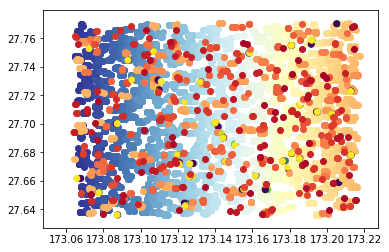

In [23]:
lst = df2.OBJECT_ID_WORLD.unique()
minma = min(lst)
maxma = max(lst)

norm = colors.Normalize(vmin=minma, vmax=maxma, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.RdYlBu_r)

for obj_id in lst:
    gh = df2[df2.OBJECT_ID_WORLD == obj_id]
    ras = gh.XWIN_WORLD.values
    decs = gh.YWIN_WORLD.values
    plt.scatter(ras, decs, c=mapper.to_rgba(obj_id))

In [830]:
#from sklearn.cluster import DBSCAN

In [ ]:
#db = DBSCAN(eps=0.01, min_samples=27)

In [880]:
# found moving objs (or flashes) (write that comparison with coadded image done)
#for obj_id in df2.OBJECT_ID_WORLD.unique():
    #print df2[df2.OBJECT_ID_WORLD == obj_id].shape, len(df2[df2.OBJECT_ID_WORLD == obj_id].CATALOG_NUM.unique())

In [760]:
#df_fin_2 = df2.loc[(df2.XWIN_IMAGE > 495) & (df2.XWIN_IMAGE < 542) \
                    #& (df2.YWIN_IMAGE > 495) & (df2.YWIN_IMAGE < 542)]

In [1244]:
np.random.uniform(low=0.99, high=1.001, size=27)

array([ 0.99619835,  0.99276703,  0.99537075,  0.9915878 ,  0.99828572,
        0.99664769,  0.9903394 ,  0.99491518,  0.99506799,  0.99065759,
        0.99180399,  1.00096547,  0.99768051,  0.99424946,  0.99009158,
        0.99807522,  0.99433296,  0.99231376,  0.99795535,  0.99035071,
        0.9960605 ,  0.99579293,  0.99298007,  1.00093094,  0.99516554,
        0.99317922,  1.00043446])

In [24]:
n_objs = len(df2.OBJECT_ID_WORLD.unique())
max_len = 27

In [25]:
def moving_average(interval, window_size): 
    window = np.ones(int(window_size))/float(window_size) 
    return np.convolve(interval, window, 'valid')

fluxes = np.zeros((n_objs, max_len))
for obj_id in xrange(n_objs):
    param_mat = df2[df2.OBJECT_ID_WORLD == obj_id][['MAG_AUTO', 'CATALOG_NUM']].as_matrix()
    flux_mean = np.mean(param_mat[:,0])
    flux_std = np.std(param_mat[:,0])
    if obj_id == 59 or True:
        flux_list = []
        idx = 0
        for cat_num in xrange(1, 28):
            if cat_num not in param_mat[:,1]:
                flux_list.append(np.mean(flux_list[:-1] if flux_list[:-1] else flux_mean))
            else:
                flux_list.append(param_mat[idx, 0])
                idx += 1
        flux = np.array(flux_list)
    #print flux, flux_list
    #flux = normalize(flux.reshape(1,-1)).ravel()
    fluxes[obj_id] = flux
    
print fluxes.shape    

(1174, 27)


In [29]:
from sklearn.cluster import KMeans
bc = KMeans(n_clusters=6)
bc.fit(fluxes)
bc.labels_

array([1, 1, 1, ..., 5, 0, 3], dtype=int32)

In [146]:
rare = []
for obj_id in xrange(n_objs):
    if len(df2[df2.OBJECT_ID_WORLD == obj_id].CATALOG_NUM.unique()) < 2:
        rare.append(obj_id)
len(rare)

4

cluster: 0


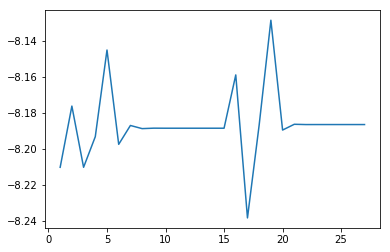

cluster: 1


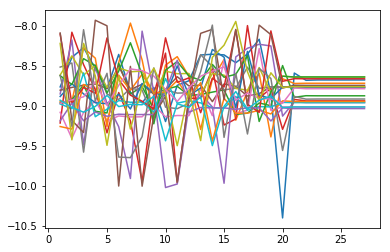

cluster: 2


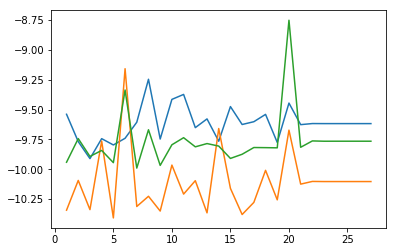

cluster: 3


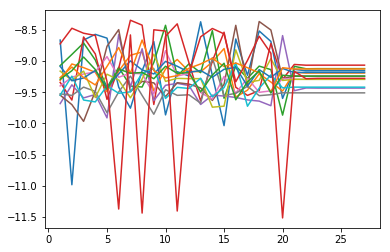

cluster: 4


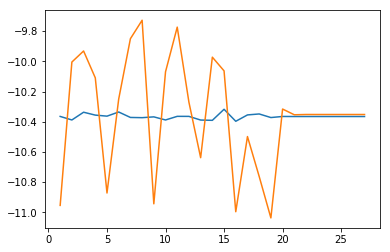

cluster: 5


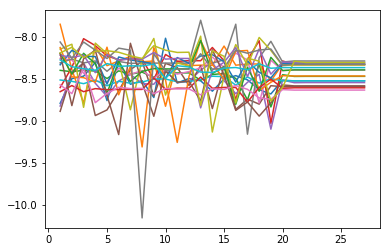

In [30]:
for obj_cl in np.unique(bc.labels_):
    print 'cluster:', obj_cl
    for obj_id in xrange(n_objs):
        if obj_cl == bc.labels_[obj_id] and obj_id <=59:
            plt.plot(range(1,28), fluxes[obj_id])
    plt.show()

In [1386]:
for obj_if in df2.OBJECT_ID_WORLD.unique():
    mean_flus = np.mean()

TypeError: mean() takes at least 1 argument (0 given)

In [412]:
df_fin = all_catalogs_df.loc[(all_catalogs_df.XWIN_IMAGE > 495) & (all_catalogs_df.XWIN_IMAGE < 542) \
                    & (all_catalogs_df.YWIN_IMAGE > 495) & (all_catalogs_df.YWIN_IMAGE < 542)]

coadded_df = coadded_df.loc[(coadded_df.XWIN_IMAGE > 495) & (coadded_df.XWIN_IMAGE < 542) \
                    & (coadded_df.YWIN_IMAGE > 495) & (coadded_df.YWIN_IMAGE < 542)]

In [418]:
coadded_df.X

,XWIN_WORLD,X2WIN_WORLD,YWIN_WORLD,X2WIN_WORLD,FLUX_AUTO,FLUXERR_AUTO
84,173.133698,4.487870e-07,27.697637,4.487870e-07,13155.604492,310.444244


In [873]:
#df_fin[['XWIN_WORLD','X2WIN_WORLD','YWIN_WORLD','X2WIN_WORLD','FLUX_AUTO', 'FLUXERR_AUTO']]

### Local hardcoded pipelines (testing astromatic software)

In [68]:
# by defualt, we search for images in paths['images']
def pipeline_1(paths):
    print "prepare..."
    # prepare
    fits_format = 'fit'
    filenames = sorted(get_fits_images_from_dir(paths['images'], files_format=fits_format))
    exposures = []
    for filename in filenames:
        exposures.append({'image': os.path.join(paths['images'], filename)})
    # STEP 1: basic extraction with SExtractor (generate catalogs) for each image
    catalog_names = []
    print 'begin SExtractor execution'
    for files in exposures:
        print files['image'] + ':'
        # Create names for the output catalogs for each image (in temp dir)
        catalog_names.append(os.path.join(paths['temp'],
            os.path.basename(files['image']).replace('.'+fits_format, '.cat')))
        # set params for sextractor execution
        sex_kwargs_1 = {'code': 'SExtractor'}
        sex_kwargs_1['config_file'] = os.path.join(paths['config'], 'default.sex')
        sex_kwargs_1['config'] = {'CATALOG_NAME': catalog_names[-1]}
        sex_kwargs_1['config']['CATALOG_TYPE'] = 'FITS_LDAC'
        sex_kwargs_1['config']['FILTER'] = 'N'
        sex_kwargs_1['temp_path'] = paths['temp']
        sex_kwargs_1['params'] = ['NUMBER', 'EXT_NUMBER', 'XWIN_IMAGE', 'YWIN_IMAGE', 'AWIN_IMAGE', 'BWIN_IMAGE',
                                  'ERRAWIN_IMAGE','ERRBWIN_IMAGE', 'ERRTHETAWIN_IMAGE', 'ERRA_WORLD', 'ERRB_WORLD', 
                                  'ERRTHETA_WORLD', 'X_WORLD', 'Y_WORLD', 'XWIN_WORLD', 'YWIN_WORLD', 
                                  'FLUX_AUTO', 'FLUX_MAX', 'MAG_AUTO', 'FLUXERR_AUTO', 
                                  'FLAGS', 'FLUX_RADIUS', 'ELONGATION']
        sextractor = aw.api.Astromatic(**sex_kwargs_1)
        print sextractor.run(files['image'])
    print 'all catalogs successfully created'
    
    # STEP 2: compute solution for extracted catalogs
    print 'SCAMP now working...'
    scamp_kwargs_1 = {
        'config': {
            'ASTREF_CATALOG': 'USNO-B1',
            'ASTREF_BAND': 'DEFAULT',
            'SOLVE_PHOTOM': 'N',
            'CHECKPLOT_DEV': 'NULL'
            }
    }
    scamp_kwargs_1['code'] = 'SCAMP'
    scamp_kwargs_1['config_file'] = os.path.join(paths['config'], 'default.scamp')
    scamp = aw.api.Astromatic(**scamp_kwargs_1)
    this_cmd, kwargs2 = scamp.build_cmd(catalog_names, **scamp_kwargs_1)
    #print this_cmd
    print scamp.run(catalog_names)
    
    print 'SWarp now working...'
    # STEP 3: use SWarp for coadd images using .head files, computed with SCAMP
    coadd_fits_name = 'coadded.fits'
    coadd_fits_filename = os.path.join(paths['temp'], coadd_fits_name)
    swarp_kwargs_1 = {
        'config': {
            'IMAGEOUT_NAME': coadd_fits_filename,
            'WEIGHTOUT_NAME': coadd_fits_filename.replace('.fits','.wtmap.fits'),
        }
        }
    swarp_kwargs_1['code'] = 'SWarp'
    swarp_kwargs_1['config_file'] = os.path.join(paths['config'], 'default.swarp')
    swarp = aw.api.Astromatic(**swarp_kwargs_1)
    this_cmd, kwargs2 = swarp.build_cmd([exp['image'] for exp in exposures], **swarp_kwargs_1)
    #print this_cmd
    print swarp.run([exp['image'] for exp in exposures])
    #return
    # STEP 4: extract object from coadded image using PSF
    print 'SExtractor now working...'
    coadd_weight_map = coadd_fits_filename.replace('.fits','.wtmap.fits')
    sex_kwargs_2 = {
            'config': {
                'CATALOG_NAME': coadd_fits_filename.replace('.fits', '.cat'),
                'CATALOG_TYPE': 'FITS_LDAC',
                'FILTER': 'N',
                'WEIGHT_IMAGE': coadd_weight_map,
                'WEIGHT_TYPE': 'MAP_WEIGHT',        
            },
            'params': ['NUMBER', 'EXT_NUMBER', 'XWIN_IMAGE', 'YWIN_IMAGE', 'ERRAWIN_IMAGE',
                'ERRBWIN_IMAGE', 'ERRTHETAWIN_IMAGE', 'XWIN_WORLD', 'YWIN_WORLD', 'FLUX_APER(1)',
                'FLUXERR_APER(1)', 'FLAGS', 'FLAGS_WEIGHT', 'FLUX_RADIUS',
                'ELONGATION', 'VIGNET(20,20)', 'SNR_WIN']
        }
    sex_kwargs_2['code'] = 'SExtractor'
    sex_kwargs_2['config_file'] = os.path.join(paths['config'], 'default.sex')
    sex_kwargs_2['temp_path'] = paths['temp']
    sextractor = aw.api.Astromatic(**sex_kwargs_2)
    print sextractor.run(coadd_fits_filename)
    
    # Calculate PSF
    print 'PSFex now working...'
    psf_kwargs_1 = {
        'config': {
            'PHOT_APERTURES':'15'
            'CENTER_KEYS': 'XWIN_IMAGE,YWIN_IMAGE',
            'PSFVAR_KEYS': 'XWIN_IMAGE,YWIN_IMAGE',
            'PHOTFLUX_KEY': 'FLUX_AUTO',
            'PHOTFLUXERR_KEY': 'FLUXERR_AUTO',
            'CHECKPLOT_DEV': 'NULL',
            'STABILITY_TYPE':  'EXPOSURE',
            'PSF_SUFFIX': '.psf'
        }
    }
    psf_kwargs_1['code'] = 'PSFEx'
    psf_kwargs_1['config_file'] = os.path.join(paths['config'], 'default.psfex')
    psf_kwargs_1['temp_path'] = paths['temp']
    psfex = aw.api.Astromatic(**psf_kwargs_1)
    print psfex.run(coadd_fits_filename.replace('.fits', '.cat'))
    
    # Calculate PSF photometry for coadded image
    print 'SExtractor now working...'
    output_cat_name = 'result.ldac.fits'
    catalog_name = os.path.join(paths['catalogs'], output_cat_name)
    sex_kwargs_3 = {
            'config': {
                'PSF_NAME': os.path.join(coadd_fits_filename.replace('.fits', '.psf')),
                'CATALOG_TYPE': 'FITS_LDAC',
                'FILTER': 'N',
                'CATALOG_NAME': catalog_name,
                'WEIGHT_IMAGE': coadd_weight_map,
                'WEIGHT_TYPE': 'MAP_WEIGHT',
            },
            'params': ['NUMBER', 'EXT_NUMBER', 'XWIN_IMAGE', 'YWIN_IMAGE', 'ERRAWIN_IMAGE',
                'ERRBWIN_IMAGE', 'ERRTHETAWIN_IMAGE', 'XWIN_WORLD', 'YWIN_WORLD', 'FLUX_AUTO',
                'FLUXERR_AUTO', 'FLAGS', 'FLAGS_WEIGHT', 'FLUX_RADIUS',
                'ELONGATION', 'MAG_AUTO', 'MAGERR_AUTO', 'ALPHAPSF_SKY', 'DELTAPSF_SKY',
                'ERRX2PSF_WORLD','ERRY2PSF_WORLD', 'FLUX_PSF', 'FLUXERR_PSF', 'MAG_PSF', 'MAGERR_PSF']
        }
    sex_kwargs_3['code'] = 'SExtractor'
    sex_kwargs_3['config_file'] = os.path.join(paths['config'], 'default.sex')
    sex_kwargs_3['temp_path'] = paths['temp']
    sextractor = aw.api.Astromatic(**sex_kwargs_3)
    print sextractor.run(coadd_fits_filename)
    return catalog_name

In [70]:
catalog_name = pipeline_1(paths)
#catalog = aw.utils.ldac.get_table_from_ldac(catalog_name)
#catalog

prepare...
begin SExtractor execution
/home/ser/Dev/astro_engine/spark_pipeline/spark_pipeline_test_1/images/GRB130427_R60_001_001.fit:
{'status': 'success'}
/home/ser/Dev/astro_engine/spark_pipeline/spark_pipeline_test_1/images/GRB130427_R60_001_002.fit:
{'status': 'success'}
all catalogs successfully created
SCAMP now working...
{'status': 'success'}
SWarp now working...
{'status': 'success'}


## Test pipeline components

In [29]:
def build_pipeline(pipeline, exposures, ref_catalog='IKI', ref_band='DEFAULT',
        stack_name = 'test_stack.fits', output_cat_name='test_psf.ldac.fits'):
    # Generate catalogs from sextractor
    catalog_names = []
    for files in exposures:
        # Create names for the output catalogs for each image
        catalog_names.append(os.path.join(pipeline.paths['temp'],
            os.path.basename(files['image']).replace('.fit', '.cat')))
        kwargs = {
            # image to SExtract
            'files': files,
            # Arguments to initialize Astromatic class
            'api_kwargs': {
                # Configuration parameters
                'config': {
                    'CATALOG_NAME': catalog_names[-1],
                    'CATALOG_TYPE': 'FITS_LDAC',
                    'FILTER': 'N',
                    #'WEIGHT_TYPE': 'MAP_WEIGHT',
                },
                # Output parameters
                'params': ['NUMBER', 'EXT_NUMBER', 'XWIN_IMAGE', 'YWIN_IMAGE', 'ERRAWIN_IMAGE',
                    'ERRBWIN_IMAGE', 'ERRTHETAWIN_IMAGE', 'XWIN_WORLD', 'YWIN_WORLD', 'FLUX_AUTO',
                    'FLUXERR_AUTO', 'IMAFLAGS_ISO', 'FLAGS', 'FLAGS_WEIGHT', 'FLUX_RADIUS',
                    'ELONGATION'],
            },
        }
        # Add the step to the pipeline
        pipeline.add_step(aw.api.run_sex, ['step1', 'SExtractor'], **kwargs)

    # Use SCAMP to get astrometric solutions
    kwargs = {
        'catalogs': catalog_names,
        'api_kwargs': {
            'config': {
                'ASTREF_CATALOG': ref_catalog,
                'ASTREF_BAND': ref_band,
                'SOLVE_PHOTOM': 'N',
                'CHECKPLOT_DEV': 'NULL'
            },
        }
    }
    pipeline.add_step(aw.api.run_scamp, ['step2', 'SCAMP'],**kwargs)

    # Resample (rotate and scale) and combine (stack) images using SWarp
    stack_filename = os.path.join(pipeline.paths['temp'], stack_name)
    kwargs = {
        'filenames': [exp['image'] for exp in exposures],
        'api_kwargs': {
            'config': {
                'WEIGHT_TYPE': 'MAP_WEIGHT',
                'WEIGHT_SUFFIX': '.wtmap.fits',
                'IMAGEOUT_NAME': stack_filename,
                'WEIGHTOUT_NAME': stack_filename.replace('.fits','.wtmap.fits'),
            },
        }
    }
    pipeline.add_step(aw.api.run_swarp, ['step3', 'SWarp'], **kwargs)

    # Get positions in stack for PSF photometry (SExtractor -> PSFex -> SExtractor)
    kwargs = {
        'files': {
            'image': stack_filename,
            'wtmap': stack_filename.replace('.fits', '.wtmap.fits')
        },
        'api_kwargs': {
            'config': {
                'CATALOG_TYPE': 'FITS_LDAC',
                'FILTER': 'N',
                'WEIGHT_TYPE': 'MAP_WEIGHT',
            },
            'params': ['NUMBER', 'EXT_NUMBER', 'XWIN_IMAGE', 'YWIN_IMAGE', 'ERRAWIN_IMAGE',
                'ERRBWIN_IMAGE', 'ERRTHETAWIN_IMAGE', 'XWIN_WORLD', 'YWIN_WORLD', 'FLUX_APER(1)',
                'FLUXERR_APER(1)', 'FLAGS', 'FLAGS_WEIGHT', 'FLUX_RADIUS',
                'ELONGATION', 'VIGNET(20,20)', 'SNR_WIN'],
        }
    }
    pipeline.add_step(aw.api.run_sex, ['step4', 'SExtractor'], **kwargs)

    # Calculate PSF
    kwargs = {
        'catalogs': stack_filename.replace('.fits', '.cat'),
        'api_kwargs': {
            'config': {
                'CENTER_KEYS': 'XWIN_IMAGE,YWIN_IMAGE',
                'PSFVAR_KEYS': 'XWIN_IMAGE,YWIN_IMAGE',
                'CHECKPLOT_DEV': 'NULL',
                'PSF_SUFFIX': '.psf'
            }
        }
    }
    pipeline.add_step(aw.api.run_psfex, ['step5', 'PSFEx'], **kwargs)

    # Calculate PSF photometry for coadded image
    catalog_name = os.path.join(pipeline.paths['catalogs'], output_cat_name)
    kwargs = {
        'files': {
            'image': stack_filename,
            'wtmap': stack_filename.replace('.fits', '.wtmap.fits')
        },
        'api_kwargs': {
            'config': {
                'PSF_NAME': os.path.join(stack_filename.replace('.fits', '.psf')),
                'CATALOG_TYPE': 'FITS_LDAC',
                'FILTER': 'N',
                'CATALOG_NAME': catalog_name,
                'WEIGHT_TYPE': 'MAP_WEIGHT',
            },
            'params': ['NUMBER', 'EXT_NUMBER', 'XWIN_IMAGE', 'YWIN_IMAGE', 'ERRAWIN_IMAGE',
                'ERRBWIN_IMAGE', 'ERRTHETAWIN_IMAGE', 'XWIN_WORLD', 'YWIN_WORLD', 'FLUX_AUTO',
                'FLUXERR_AUTO', 'FLAGS', 'FLAGS_WEIGHT', 'FLUX_RADIUS',
                'ELONGATION', 'MAG_AUTO', 'MAGERR_AUTO', 'ALPHAPSF_SKY', 'DELTAPSF_SKY',
                'ERRX2PSF_WORLD','ERRY2PSF_WORLD', 'FLUX_PSF', 'FLUXERR_PSF', 'MAG_PSF', 'MAGERR_PSF'],
        }
    }
    pipeline.add_step(aw.api.run_sex, ['step6', 'SExtractor'], **kwargs)

    def save_output(pipeline, old_stack, new_stack, old_cat, new_cat):
        # Copy the final stack and catalog from the temp folder
        import shutil
        # Move the weight map if it exists
        if os.path.isfile(old_stack.replace('.fits', '.wtmap.fits')):
            shutil.move(old_stack.replace('.fits', '.wtmap.fits'), new_stack.replace('.fits', '.wtmap.fits'))
        shutil.move(old_stack, new_stack)
        shutil.move(old_cat, new_cat)
        result = {
            'status': 'success'
        }
        return result

    kwargs = {
        'old_stack': stack_filename,
        'new_stack': os.path.join(pipeline.paths['stacks'], stack_name),
        'old_cat': catalog_name,
        'new_cat': os.path.join(pipeline.paths['catalogs'], output_cat_name)
    }
    pipeline.add_step(save_output, ['step7', 'save_output'], **kwargs)

    return pipeline